### 🌾 🇼​​🇭​​🇪​​🇦​​🇹​ ​​🇲​​🇴​​🇳​​🇹​​🇭​​🇱​​🇾​ 🇵​​🇷​​🇮​​🇨​​🇪​ ​🇫​​🇴​​🇷​​🇪​​🇨​​🇦​​🇸​​🇹​

Researcher: [Andrew Batyrov](https://www.kaggle.com/semipro), (C) Dec, 2024

##### <a id="toc"></a>Table of Contents

[Description](#description)

1. [Source Data](#data)

2. [Data Analysis](#analysis)
   
   2.1. [EDA](#eda)

   2.2. [Price as Time Series](#time-series)

3. [Forecast Models](#modeling)

    3.1. [Linear Regression](#linreg)

    3.2. [SARIMAX](#sarimax)

4. [Cross-validation](#cross-val)

5. [Forecast](#forecast)

[Summary](#summary)

---
##### <a id="description"></a>Description

Price data can be found here: 
- Target: [Milling Wheat N2 Futures](https://investing.com/commodities/milling-wheat-n2 )
- Exogenous regressors:
  - [SGE Gold](https://investing.com/commodities/sge-gold-t-d-cny-cash-spot-futures)
  - [London Gas Oil Futures](https://investing.com/commodities/london-gas-oil)
  - [Brent Oil Futures](https://investing.com/commodities/brent-oil)
  - [US Soybean Meal Futures](https://investing.com/commodities/us-soybean-meal?cid=1178333)

Goal or research:
- examine the data,
- build a forecasting model for wheat prices,
- generate a 3-month-ahead forecast for wheat prices.

[TOC](#toc)

---
##### <a id="data"></a>1. Source Data

Monthly prices for the following commodities: Milling Wheat (target) and SGE Gold, Gas Oil, Brent Oil, Soybean (exogenous regressors) were downloaded and saved as csv files.

Each file has the following fields:
- Date
- Price (close)
- Open
- High
- Low
- Vol.
- Change %

We will use the close price as our target variable for forecasting.

Python libraries requirements:
- matplotlib==3.7.2
- numpy==1.25.2
- pandas==2.0.3
- scikit_learn==1.4.0
- scipy==1.11.1
- statsmodels==0.14.0
- tqdm==4.65.2

In [1]:
# Install Python libraries, if needed
# %pip install matplotlib==3.7.2
# %pip install numpy==1.25.2
# %pip install pandas==2.0.3
# %pip install scikit_learn==1.4.0
# %pip install scipy==1.11.1
# %pip install statsmodels==0.14.0
# %pip install tqdm==4.65.2

In [2]:
import warnings
warnings.filterwarnings('ignore', module='statsmodels')
from itertools import product
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import tqdm
from helper import (describe, 
                    plot_hist, 
                    plot_trace, 
                    plot_pacf, 
                    plot_bar, 
                    plot_decomposition, 
                    plot_goodness, 
                    plot_true_pred_scat, 
                    plot_true_pred_trace, 
                    plot_forecast,
                    run_adf_test)
alpha = 0.05 # Statistical significance level

In [3]:
# Load data into one dataframe
asset_names = ['milling_wheat', 'sge_gold', 'gas_oil', 'brent_oil', 'soybean']
date_index = pd.date_range(start='1970-01-01', end='2024-12-01', freq='MS').strftime('%d.%m.%Y')
data = pd.DataFrame(columns=[f'Price_{_}' for _ in asset_names], index=date_index).reset_index(names='Date')
for asset_name in asset_names:
    col_name = f'Price_{asset_name}'
    asset_data = pd.read_csv(f'./data/{asset_name}.csv', 
                             decimal=',', 
                             thousands='.', 
                             usecols=[0, 1], 
                             header=0, 
                             names=['Date', col_name], 
                             dtype={'Date': str, col_name: float})
    data = data.merge(asset_data, how='inner', on='Date', suffixes=('_', '')) # Merge csv files
data = data.dropna(axis=1, how='all')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.reset_index(names='Date_idx') # Index for date
data = data.set_index('Date')
data = data.asfreq('MS') # Each date -- month start
data.shape

(244, 6)

In [4]:
print(f'Date span: {data.index.min()} -- {data.index.max()}')

Date span: 2004-09-01 00:00:00 -- 2024-12-01 00:00:00


In [5]:
data.dtypes

Date_idx                 int64
Price_milling_wheat    float64
Price_sge_gold         float64
Price_gas_oil          float64
Price_brent_oil        float64
Price_soybean          float64
dtype: object

In [6]:
# Check for missing values
data.isna().sum()

Date_idx               0
Price_milling_wheat    0
Price_sge_gold         0
Price_gas_oil          0
Price_brent_oil        0
Price_soybean          0
dtype: int64

In [7]:
data

,Date_idx,Price_milling_wheat,Price_sge_gold,Price_gas_oil,Price_brent_oil,Price_soybean
Date,,,,,,
2004-09-01,0,108.50,108.73,429.25,46.38,161.1
2004-10-01,1,108.50,112.85,437.50,48.98,157.9
2004-11-01,2,107.50,119.07,427.50,45.51,157.3
2004-12-01,3,106.00,116.94,365.25,40.46,165.0
2005-01-01,4,107.25,113.10,393.25,45.92,155.3
...,...,...,...,...,...,...
2024-08-01,239,205.75,573.59,696.50,76.93,313.0
2024-09-01,240,222.25,595.25,659.50,71.70,341.9
2024-10-01,241,218.00,634.00,669.00,73.16,304.0


[TOC](#toc)

---
##### <a id="analysis"></a>2. Data Analysis

<a id="eda"></a>2.1. EDA

r = 0.55
0 nulls
Min = 101.50
Max = 400.75
Med = 187.50


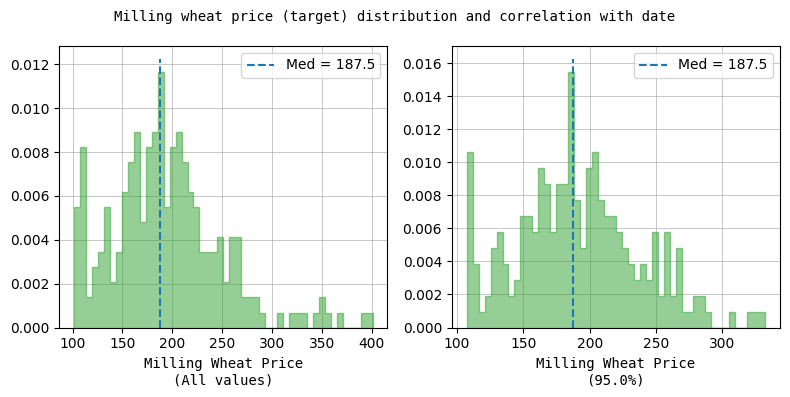

In [8]:
# Milling Wheat (target)
target = 'Price_milling_wheat'
print(f"r = {np.corrcoef(data['Date_idx'], data[target].values)[0, 1]:.2f}")
describe(data[target], 'num')
plot_hist(data[target].values, None, 50, 95.0, 'Milling Wheat Price', 'Milling wheat price (target) distribution and correlation with date')

r = 0.60
0 nulls
Min = 108.73
Max = 634.00
Med = 273.84


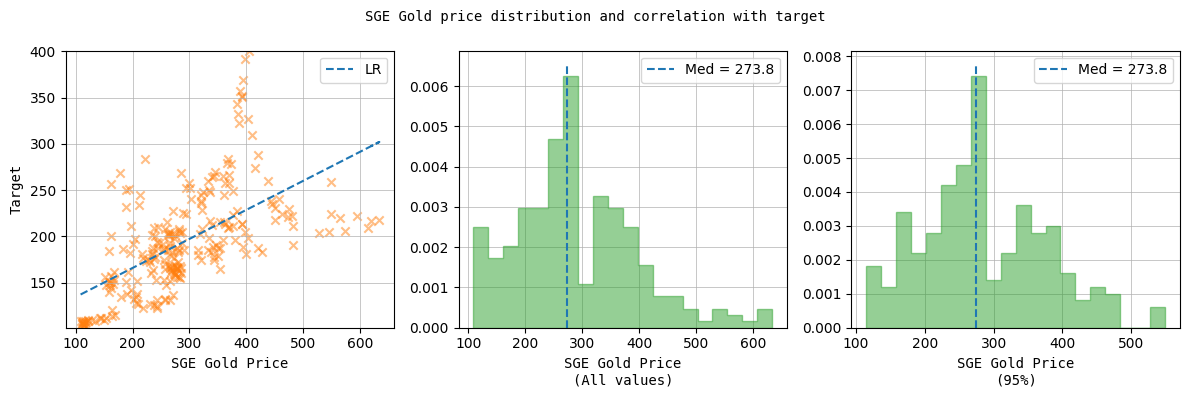

In [9]:
# SGE Gold
print(f"r = {data['Price_sge_gold'].corr(data[target]):.2f}")
describe(data['Price_sge_gold'], 'num')
plot_hist(data['Price_sge_gold'].values, data[target].values, 20, 95, 'SGE Gold Price', 'SGE Gold price distribution and correlation with target')

r = 0.61
0 nulls
Min = 236.75
Max = 1,268.50
Med = 637.88


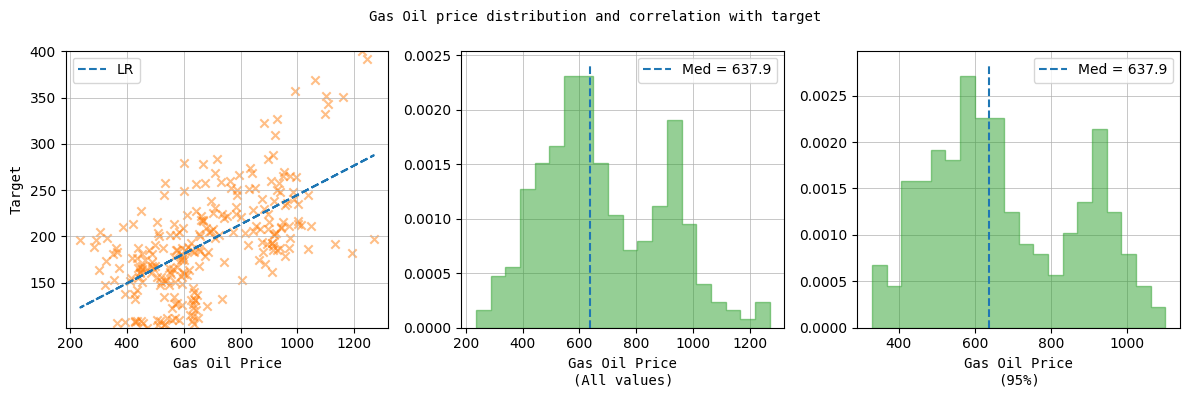

In [10]:
# Gas Oil
print(f"r = {data['Price_gas_oil'].corr(data[target]):.2f}")
describe(data['Price_gas_oil'], 'num')
plot_hist(data['Price_gas_oil'].values, data[target].values, 20, 95, 'Gas Oil Price', 'Gas Oil price distribution and correlation with target')

r = 0.51
0 nulls
Min = 26.35
Max = 139.83
Med = 72.66


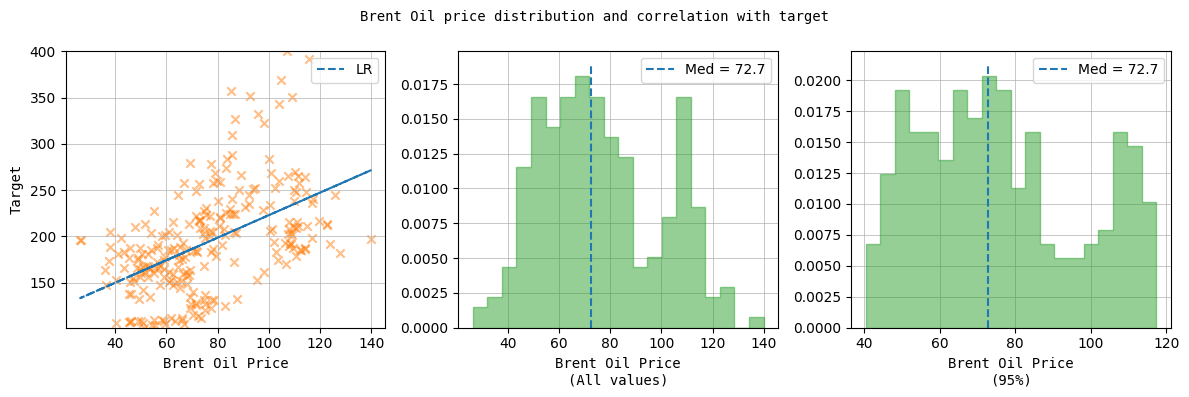

In [11]:
# Brent Oil
print(f"r = {data['Price_brent_oil'].corr(data[target]):.2f}")
describe(data['Price_brent_oil'], 'num')
plot_hist(data['Price_brent_oil'].values, data[target].values, 20, 95, 'Brent Oil Price', 'Brent Oil price distribution and correlation with target')

r = 0.73
0 nulls
Min = 155.30
Max = 533.40
Med = 323.15


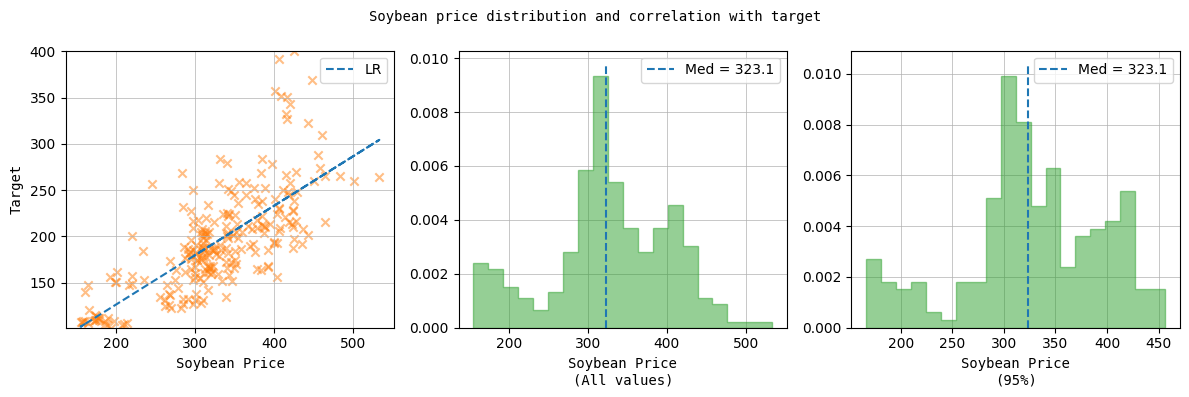

In [12]:
# Soybean
print(f"r = {data['Price_soybean'].corr(data[target]):.2f}")
describe(data['Price_soybean'], 'num')
plot_hist(data['Price_soybean'].values, data[target].values, 20, 95, 'Soybean Price', 'Soybean price distribution and correlation with target')

In [13]:
# Pearson correlation matrix
corr_df = data.drop(columns=['Date_idx']).corr()
corr_df = corr_df.where(np.identity(corr_df.shape[0]) != 1.0, np.nan) # Exclude "auto" correlation
(corr_df
    .style.format(na_rep='-', formatter=lambda x: f'{x:.2f}')
    .highlight_between(left=0.5, right=1.0, color='palegreen')
    .highlight_between(right=-0.5, left=-1.0, color='palegreen')
    .highlight_between(left=0.9, right=1.0, color='yellow')
    .highlight_between(right=-0.9, left=-1.0, color='yellow')
    .set_caption(f'<h4>Pearson correlation matrix for all variables</h4>')
)

,Price_milling_wheat,Price_sge_gold,Price_gas_oil,Price_brent_oil,Price_soybean
Price_milling_wheat,-,0.60,0.61,0.51,0.73
Price_sge_gold,0.60,-,0.26,0.20,0.58
Price_gas_oil,0.61,0.26,-,0.96,0.56
Price_brent_oil,0.51,0.20,0.96,-,0.54
Price_soybean,0.73,0.58,0.56,0.54,-


[TOC](#toc)

<a id="time-series"></a>2.2. Price as Time Series

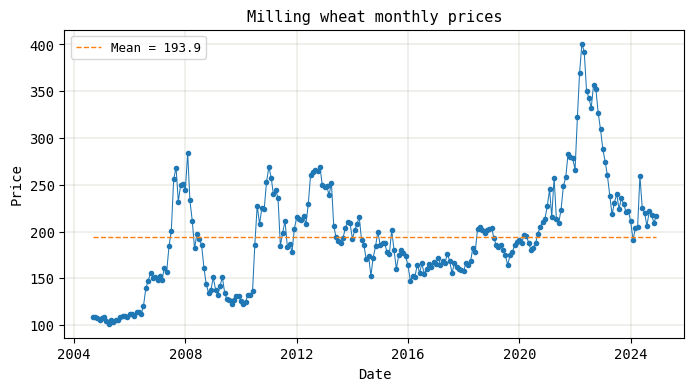

In [14]:
plot_trace(data, target, 'Date', 'Price', 'Milling wheat monthly prices')

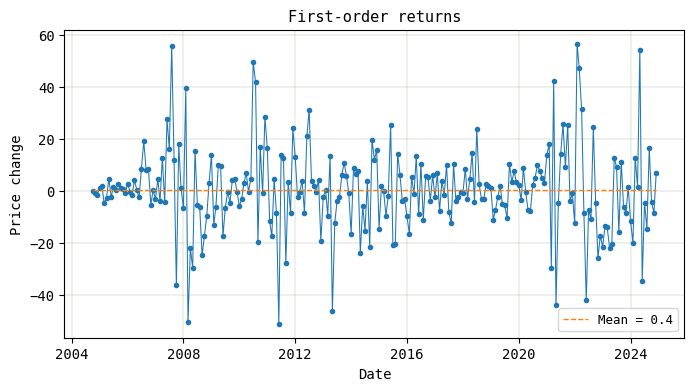

In [15]:
plot_trace(data.diff().dropna(), target, 'Date', 'Price change', 'First-order returns')

Although the price visually exhibits significant fluctuations from the mean, the first differences oscillate around zero.

Let's test for stationarity using the Augmented Dickey-Fuller (ADF) test.
- $\mathcal{H_0}$: Time series is non-stationary.
- $\mathcal{H_1}$: Time series is stationary.

In [16]:
print('Milling wheat price: ', end='')
run_adf_test(data, target, alpha)
print('First-order returns: ', end='')
run_adf_test(data.diff().dropna(), target, alpha)

Milling wheat price: adf_stats =  -3.28, adf_pval = 0.02, Stationary for alpha = 0.05
First-order returns: adf_stats = -15.05, adf_pval = 0.00, Stationary for alpha = 0.05


Additionally, we will examine the correlogram of the target over a year (12 months) using the partial autocorrelation function (PACF).

PACF(1) = 0.96


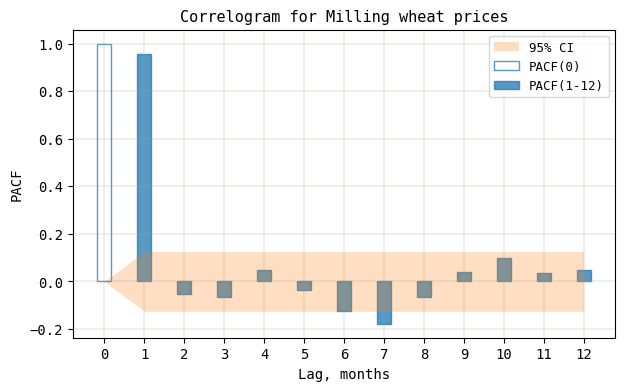

In [17]:
plot_pacf(data, target, 12, alpha, 'Lag, months', 'Correlogram for Milling wheat prices')

The correlogram shows that the price in the current month is highly correlated with the price from the previous month, with a correlation coefficient of 0.96.

Finally, we will check for the presence of a seasonal component in wheat prices. As expected, wheat is a seasonal commodity influenced by its characteristics and agricultural practices. We will assess seasonality with a period of one year (12 months).

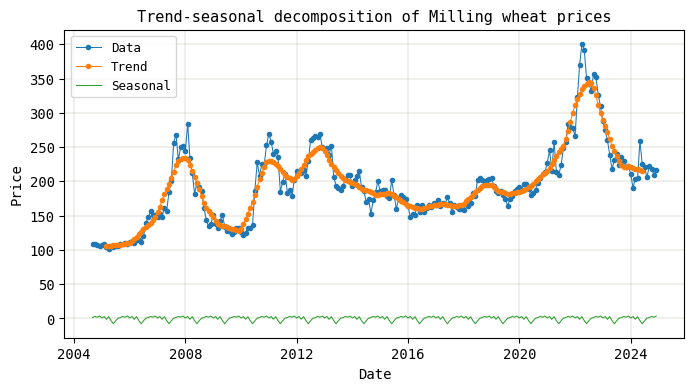

In [18]:
decompose_result = plot_decomposition(data, target, 12, 'Date', 'Price', 'Trend-seasonal decomposition of Milling wheat prices')

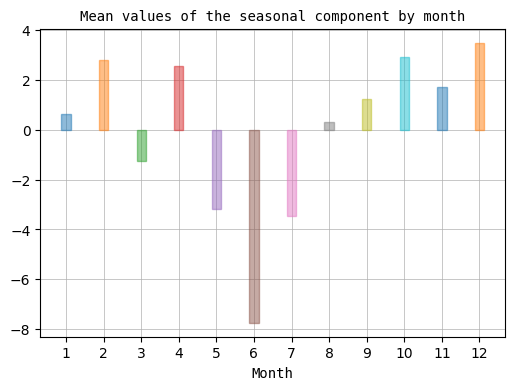

In [19]:
season_df = pd.DataFrame(decompose_result.seasonal.groupby(decompose_result.seasonal.index.month).mean())\
    .reset_index()\
    .rename(columns={'Date': 'Month', 'seasonal': 'Mean'})
plot_bar(season_df, 'Month', 'Mean', 'Month', 'Mean values of the seasonal component by month')

It is worth noting that the average monthly seasonal components of the wheat price are lower during the warmer months (in the Northern Hemisphere).

Conclusions:

- The price of Milling wheat is linearly and positively correlated with external factors ($r \ge 0.5$).
- Brent oil and Gas oil prices are highly correlated, allowing us to use only one feature to avoid collinearity.
- Since the correlation of Milling wheat prices with Gas oil is stronger than with Brent oil, we will exclude Brent oil and keep Gas oil only.
- The price of Milling wheat and its first-order differences are stationary.
- A strong first-order autoregression has been identified.
- A seasonal component is present in the price, particularly with a 12-month period.

Therefore, the future model will be built using the following data:

- Milling wheat price (target).
- Prices of SGE Gold, Gas Oil, and Soybeans (external factors).
- The model should treat the target as a time-series process.

In [20]:
data = data.drop('Price_brent_oil', axis=1)
data

,Date_idx,Price_milling_wheat,Price_sge_gold,Price_gas_oil,Price_soybean
Date,,,,,
2004-09-01,0,108.50,108.73,429.25,161.1
2004-10-01,1,108.50,112.85,437.50,157.9
2004-11-01,2,107.50,119.07,427.50,157.3
2004-12-01,3,106.00,116.94,365.25,165.0
2005-01-01,4,107.25,113.10,393.25,155.3
...,...,...,...,...,...
2024-08-01,239,205.75,573.59,696.50,313.0
2024-09-01,240,222.25,595.25,659.50,341.9
2024-10-01,241,218.00,634.00,669.00,304.0


[TOC](#toc)

---
##### <a id="modeling"></a>3. Forecast Models

<a id="linreg"></a>3.1. Linear Regression

Above, we obtained "strong" correlation coefficients between the price of wheat, the date, and the prices of other assets. Let us now attempt to build a basic linear regression model for the price, i.e., without accounting for the time-series process for now.

In [21]:
model_lr = smf.ols(f"{target} ~ {' + '.join(data.drop(target, axis=1).columns)}", data=data)
fitted_lr = model_lr.fit()

In [22]:
# Fit results
print(fitted_lr.summary())

                             OLS Regression Results                            
Dep. Variable:     Price_milling_wheat   R-squared:                       0.672
Model:                             OLS   Adj. R-squared:                  0.667
Method:                  Least Squares   F-statistic:                     122.6
Date:                 Fri, 03 Jan 2025   Prob (F-statistic):           1.01e-56
Time:                         22:21:09   Log-Likelihood:                -1192.2
No. Observations:                  244   AIC:                             2394.
Df Residuals:                      239   BIC:                             2412.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.1171      9.8

Let's calculate the model metrics.

In [23]:
print('Statistically significant parameters of the model:')
print(fitted_lr.params[fitted_lr.pvalues <= alpha].to_string())

Statistically significant parameters of the model:
Date_idx         0.286203
Price_gas_oil    0.113811
Price_soybean    0.199074


In [24]:
print(f'R2   = {fitted_lr.rsquared:>5.2f}')
print(f"RMSE = {root_mean_squared_error(data[target], fitted_lr.predict(data.drop(target, axis=1))):>5.2f}")
print(f"MAE  = {mean_absolute_error(data[target], fitted_lr.predict(data.drop(target, axis=1))):>5.2f}")

R2   =  0.67
RMSE = 32.04
MAE  = 25.14


In [25]:
print(f'DW = {durbin_watson(fitted_lr.resid):.2f}')

DW = 0.25


Conclusions:

- Not all parameters of the model turned out to be statistically significant.
- Additionally, consider the Durbin-Watson statistic for the model residuals: $DW = 0.25 < 2$, which indicates positive first-order autocorrelation. This autocorrelation was also identified in the earlier analysis above. The presence of autocorrelation violates one of the assumptions of the linear regression model: the independence of observations (prices) from each other (i.i.d.).
- **Therefore, the linear regression model is not applicable in this case.**

[TOC](#toc)

<a id="sarimax"></a>3.2. SARIMAX

We will choose the SARIMAX model (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors) as a more suitable alternative.

This linear model allows us to account for the following:

- The seasonal component of the price.
- The autocorrelation in the price.
- The non-stationarity of the price: although we confirmed stationarity, leveraging this feature of the model ensures greater robustness.
- Exogenous regressors (external factors), such as the prices of other assets.

Model Parameters:

- P - Order of seasonal autoregression (SAR).
- D - Order of seasonal differencing (SI).
- Q - Order of seasonal moving average (SMA).
- s - Seasonality period.
- p - Order of non-seasonal autoregression (AR).
- d - Order of non-seasonal differencing (I).
- q - Order of non-seasonal moving average (MA).

We will split our data into two samples:

- `train_val_df`: For training and in-sample validation of the model.
- `forecast_df`: For out-of-sample forecasting with the model.

In [26]:
train_val_df = data.loc[: '2024-09-01']
forecast_df = data.loc['2024-10-01':] # Most recent 3 months
print(f'Date span for train-val:   {train_val_df.index.min()} -- {train_val_df.index.max()}')
print(f'Date span for forecasting: {forecast_df.index.min()} -- {forecast_df.index.max()}')

Date span for train-val:   2004-09-01 00:00:00 -- 2024-09-01 00:00:00
Date span for forecasting: 2024-10-01 00:00:00 -- 2024-12-01 00:00:00


In [27]:
train_val_df

,Date_idx,Price_milling_wheat,Price_sge_gold,Price_gas_oil,Price_soybean
Date,,,,,
2004-09-01,0,108.50,108.73,429.25,161.1
2004-10-01,1,108.50,112.85,437.50,157.9
2004-11-01,2,107.50,119.07,427.50,157.3
2004-12-01,3,106.00,116.94,365.25,165.0
2005-01-01,4,107.25,113.10,393.25,155.3
...,...,...,...,...,...
2024-05-01,236,259.25,549.50,731.75,355.9
2024-06-01,237,224.75,549.30,785.50,335.7
2024-07-01,238,220.25,564.16,740.25,314.1


In [28]:
forecast_df

,Date_idx,Price_milling_wheat,Price_sge_gold,Price_gas_oil,Price_soybean
Date,,,,,
2024-10-01,241,218.0,634.0,669.00,304.0
2024-11-01,242,209.5,614.6,677.00,297.6
2024-12-01,243,216.5,619.2,669.62,298.0


We will select the optimal model parameters by iterating through all possible tuples (the Cartesian product of parameter values).
As the model's optimality metric, we will minimize the Akaike Information Criterion (AIC), which better evaluates the model's predictive capabilities.

In [29]:
Ps, ps = range(0, 2), range(0, 2)
Ds, ds = range(1, 2), range(1, 2)
Qs, qs = range(0, 2), range(0, 2)
param_prods = list(product(Ps, ps, Ds, ds, Qs, qs))
print(f'The number of parameter tuples: {len(param_prods)}')

The number of parameter tuples: 16


In [30]:
best_aic = float('inf')
best_order, best_seasonal_order = None, None
for P, p, D, d, Q, q in tqdm.tqdm(param_prods):
    model_sarimax = SARIMAX(endog=train_val_df[target], 
                            exog=train_val_df.drop(columns=[target, 'Date_idx']), 
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, 12)) # Seasonality period is 12 months
    fitted_sarimax = model_sarimax.fit()
    aic = fitted_sarimax.aic
    if aic < best_aic:
        best_aic = aic
        best_order = (p, d, q)
        best_seasonal_order = (P, D, Q)

100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


In [31]:
print(f'Best tuple for non-seasonal parameters: {best_order}')
print(f'Best tuple for seasonal parameters:     {best_seasonal_order}')

Best tuple for non-seasonal parameters: (0, 1, 0)
Best tuple for seasonal parameters:     (0, 1, 1)


Re-train the model with the optimized parameters.

In [32]:
model_sarimax = SARIMAX(endog=train_val_df[target], 
                        exog=train_val_df.drop(columns=[target, 'Date_idx']), 
                        order=best_order,
                        seasonal_order=best_seasonal_order + (12,))
fitted_sarimax = model_sarimax.fit()

In [33]:
# Fit results
print(fitted_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  Price_milling_wheat   No. Observations:                  241
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -956.862
Date:                              Fri, 03 Jan 2025   AIC                           1923.724
Time:                                      22:21:22   BIC                           1940.871
Sample:                                  09-01-2004   HQIC                          1930.642
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Price_sge_gold    -0.0121      0.094     -0.129      0.897      -0.196       0.172
Price_g

Let's calculate the model metrics.

In [34]:
print('Statistically significant parameters of the model:')
print(fitted_sarimax.params[fitted_sarimax.pvalues <= alpha].to_string())

Statistically significant parameters of the model:
Price_soybean      0.245701
ma.S.L12          -0.892188
sigma2           238.064634


In [35]:
print(f'R2   = {r2_score(train_val_df[target], fitted_sarimax.fittedvalues):>5.2f}')
print(f'RMSE = {root_mean_squared_error(train_val_df[target], fitted_sarimax.fittedvalues):>5.2f}')
print(f'MAE  = {mean_absolute_error(train_val_df[target], fitted_sarimax.fittedvalues):>5.2f}')

R2   =  0.92
RMSE = 16.05
MAE  = 11.72


Next, we will evaluate the correlation between the predicted and actual prices.

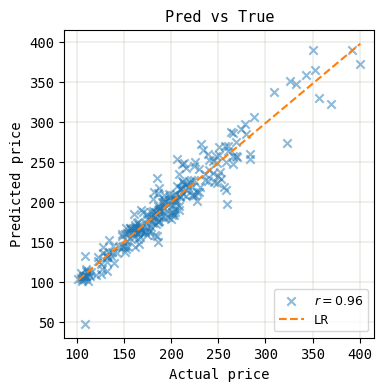

In [36]:
plot_true_pred_scat(train_val_df[target], fitted_sarimax.fittedvalues, 'Actual price', 'Predicted price')

Also, let's look at the residuals of the model's predictions.

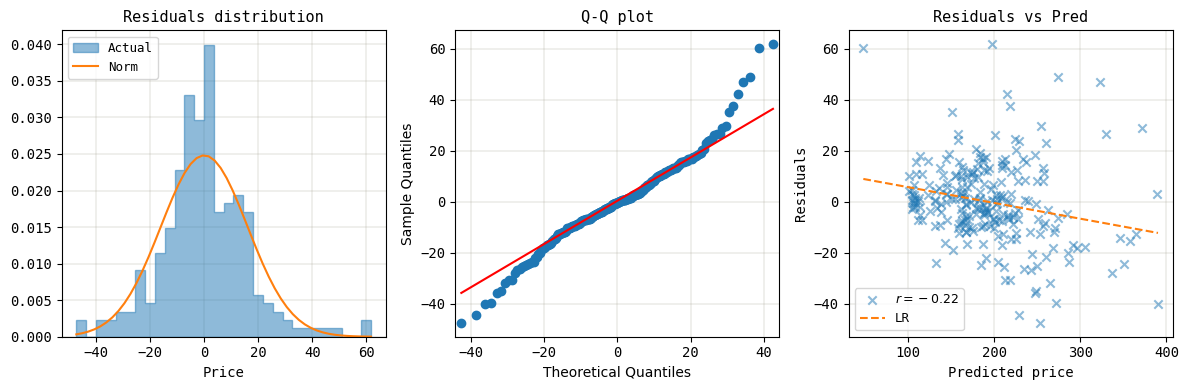

In [37]:
plot_goodness(train_val_df[target], fitted_sarimax.fittedvalues, 'Price', 'Predicted price', 'Residuals')

Finally, lst's visually evaluate the model's in-sample predictions, for example, over the last 5 years.

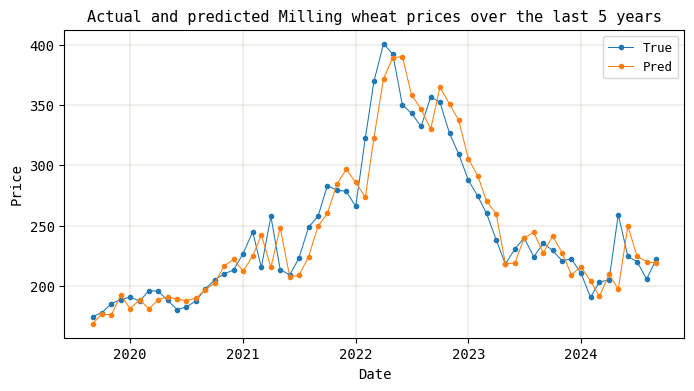

In [38]:
plot_true_pred_trace(train_val_df.loc['2019-09-01':].index, 
                  train_val_df.loc['2019-09-01':][target], 
                  fitted_sarimax.fittedvalues['2019-09-01':], 
                  'Date', 
                  'Price', 
                  'Actual and predicted Milling wheat prices over the last 5 years')

Conclusions:

- **The constructed model has a high $R^2 = 0.92$, meaning it effectively explains the variance in wheat prices based on the date and external factors.**
- The statistically significant external factor is the price of soybeans.
- The distribution of the model's residuals shows outliers.
- The residuals exhibit weak but non-zero heteroscedasticity, with a correlation coefficient between residuals and predicted price $r = -0.22$. This may be related to high-volatility regimes, as observed in the time-series plot above.

[TOC](#toc)

---
##### <a id="cross-val"></a>4. Cross-validation

After building the model, we want to ensure its stability across different time intervals for in-sample data. To achieve this, we will perform cross-validation on 10 overlapping time intervals using the rolling window method. For proper splitting of time-series data into subsets, we will use the `TimeSeriesSplit` object from the `scikit-learn` library.

In [39]:
n_windows = 10 # Number of rolling windows
ts_cv_sv_base = TimeSeriesSplit(n_splits=n_windows, max_train_size=train_val_df.shape[0] - n_windows, test_size=1, gap=0)

In [40]:
print('Window # | Date span                | Months (approx.)')
print('---------|--------------------------|-----------------')
for i, split in enumerate(ts_cv_sv_base.split(train_val_df)):
    train_start = train_val_df.iloc[split[0]].index.min().date()
    train_end = train_val_df.iloc[split[0]].index.max().date()
    print(f'{i + 1:>8} | {train_start} -- {train_end} | {(train_end - train_start).days // 30 + 1}')

Window # | Date span                | Months (approx.)
---------|--------------------------|-----------------
       1 | 2004-09-01 -- 2023-11-01 | 234
       2 | 2004-10-01 -- 2023-12-01 | 234
       3 | 2004-11-01 -- 2024-01-01 | 234
       4 | 2004-12-01 -- 2024-02-01 | 234
       5 | 2005-01-01 -- 2024-03-01 | 234
       6 | 2005-02-01 -- 2024-04-01 | 234
       7 | 2005-03-01 -- 2024-05-01 | 234
       8 | 2005-04-01 -- 2024-06-01 | 234
       9 | 2005-05-01 -- 2024-07-01 | 234
      10 | 2005-06-01 -- 2024-08-01 | 234


In [41]:
cv_results_df = pd.DataFrame(columns=['Date span', 'R2', 'RMSE', 'MAE'])

In [42]:
for split in ts_cv_sv_base.split(train_val_df):
    train_start = train_val_df.iloc[split[0]].index.min().date()
    train_end = train_val_df.iloc[split[0]].index.max().date()
    model_sarimax = SARIMAX(endog=train_val_df.loc[train_start: train_end][target], 
                            exog=train_val_df.loc[train_start: train_end].drop(columns=[target, 'Date_idx']), 
                            order=best_order,
                            seasonal_order=best_seasonal_order + (12,))
    fitted_sarimax = model_sarimax.fit()
    r2 = r2_score(train_val_df.loc[train_start: train_end][target], fitted_sarimax.fittedvalues.loc[train_start: train_end])
    rmse = root_mean_squared_error(train_val_df.loc[train_start: train_end][target], fitted_sarimax.fittedvalues.loc[train_start: train_end])
    mae = mean_absolute_error(train_val_df.loc[train_start: train_end][target], fitted_sarimax.fittedvalues.loc[train_start: train_end])
    cv_results_df.loc[len(cv_results_df)] = [f'{train_start} -- {train_end}', r2, rmse, mae]

In [43]:
cv_results_df

,Date span,R2,RMSE,MAE
0,2004-09-01 -- 2023-11-01,0.924296,15.724438,11.526782
1,2004-10-01 -- 2023-12-01,0.922686,15.824752,11.643585
2,2004-11-01 -- 2024-01-01,0.921902,15.831236,11.685557
3,2004-12-01 -- 2024-02-01,0.920480,15.894299,11.779948
4,2005-01-01 -- 2024-03-01,0.920038,15.854684,11.829141
5,2005-02-01 -- 2024-04-01,0.920634,15.713376,11.802363
6,2005-03-01 -- 2024-05-01,0.915735,16.153684,12.021346
7,2005-04-01 -- 2024-06-01,0.914505,16.185343,12.064196
8,2005-05-01 -- 2024-07-01,0.913128,16.217982,12.131935
9,2005-06-01 -- 2024-08-01,0.911346,16.287748,12.220461


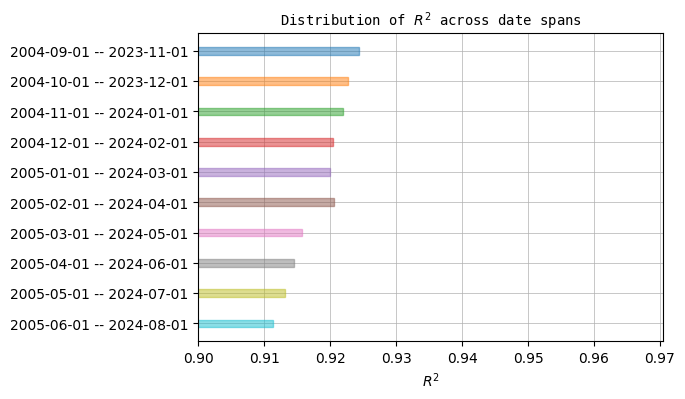

In [44]:
plot_bar(cv_results_df, 'Date span', 'R2', '$R^2$', 'Distribution of $R^2$ across date spans', 'horizontal', 0.9)

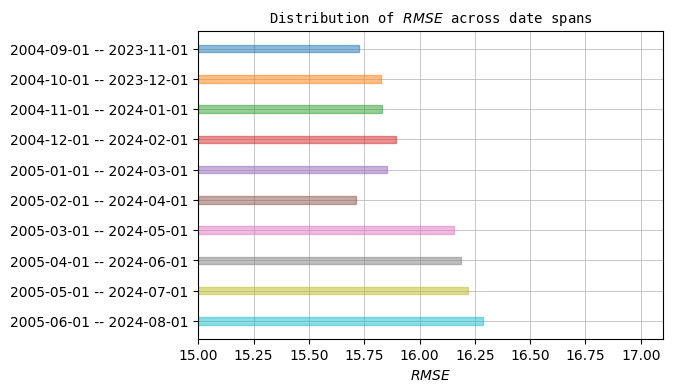

In [45]:
plot_bar(cv_results_df, 'Date span', 'RMSE', '$RMSE$', 'Distribution of $RMSE$ across date spans', 'horizontal', 15.0)

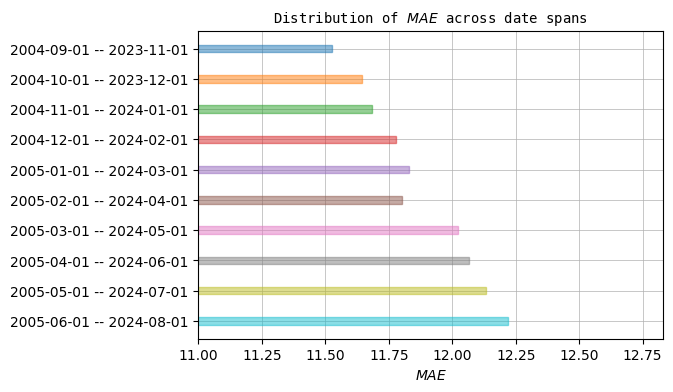

In [46]:
plot_bar(cv_results_df, 'Date span', 'MAE', '$MAE$', 'Distribution of $MAE$ across date spans', 'horizontal', 11.0)

Conclusions:
- Overall, the model metrics remain stable across different time intervals.
- There is a noticeable trend of worsening metrics for datasets from March 2005 to September 2024 (the end of the training set).

**Overall, we can consider the constructed model as suitable for forecasting.**

[TOC](#toc)

---
##### <a id="forecast"></a>5. Forecast

Let's forecast milling wheat prices for the next 3 months using the SARIMAX model we have developed and cross-validated. Since the model incorporates exogenous regressors, we will conduct the forecasting for the months with known values for these regressors, i.e., October, November, and December 2024 (out-of-sample data).

First, we will re-train the model after performing cross-validation on the in-sample data.

In [47]:
model_sarimax = SARIMAX(endog=train_val_df[target], 
                        exog=train_val_df.drop(columns=[target, 'Date_idx']), 
                        order=best_order,
                        seasonal_order=best_seasonal_order + (12,))
fitted_sarimax = model_sarimax.fit()

Next, we are generating a forecast for the out-of-sample data.

In [48]:
forecast_sarimax = fitted_sarimax.get_forecast(steps=3, exog=forecast_df.drop(columns=[target, 'Date_idx']))

The actual and forecasted wheat prices for the next 3 months.

In [49]:
forecast_mean = forecast_sarimax.predicted_mean
forecast_ci = forecast_sarimax.conf_int(alpha=alpha)
forecast_result_df = pd.concat([forecast_df[target], forecast_mean, forecast_ci], axis=1)
forecast_result_df.columns = ['Price_actual', 'Price_forecast', 'Price_forecast_lo', 'Price_forecast_hi']
forecast_result_df

,Price_actual,Price_forecast,Price_forecast_lo,Price_forecast_hi
2024-10-01,218.0,213.682614,183.409167,243.956061
2024-11-01,209.5,210.065380,167.252260,252.878499
2024-12-01,216.5,208.215164,155.780015,260.650312


Finally, let's visually assess the results of the forecasting.

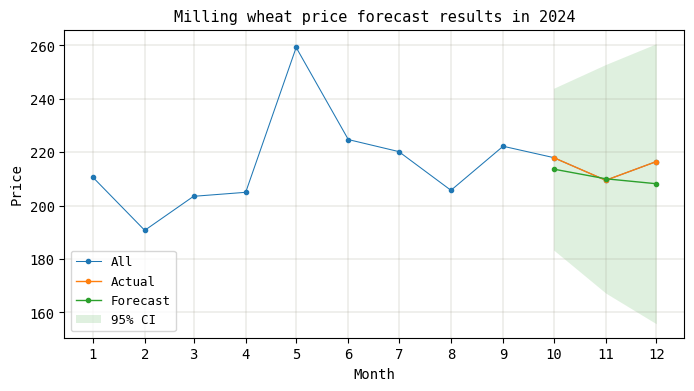

In [50]:
plot_forecast(data.loc['2024-01-01':], 
              forecast_df, 
              forecast_mean, 
              forecast_ci, 
              target, 
              1.0 - alpha, 
              'Month', 
              'Price', 
              'Milling wheat price forecast results in 2024')

Conclusions:
- We obtained a 3-month forecast for wheat prices.
- **The actual wheat prices lie within the 95% confidence interval of the model's predictions.**

[TOC](#toc)

---
##### <a id="summary"></a>Summary

- We have conducted a thorough analysis of milling wheat prices as a function of date and external factors, including correlation and trend-seasonal decomposition.
- We have demonstrated the impracticality of using a simple linear regression model.
- We have developed and validated a more complex and robust forecasting model SARIMAX with strong metrics.
- We have generated a 3-month price forecast, and the results align well with actual prices.
- As a potential model enhancement, we suggest incorporating additional external regressors, such as temperature and humidity. To do this, information on which regions and seasons these factors influence milling wheat production and pricing would be required.

[TOC](#toc)